Bài 1:
Code from scratch hàm transposed convolution

In [ ]:
import torch
import torch.nn as nn

def trans_conv(X, K):
    h, w = K.shape
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Y[i: i + h, j: j + w] += X[i, j] * K
    return Y

X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
result_custom = trans_conv(X, K)
print("Custom Transposed Convolution:")
print(result_custom)

X, K = X.reshape(1, 1, 2, 2), K.reshape(1, 1, 2, 2)
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)
tconv.weight.data = K
result_torch = tconv(X)
print("PyTorch ConvTranspose2d:")
print(result_torch)



Custom Transposed Convolution:
tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])
PyTorch ConvTranspose2d:
tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)


Bài 2: Cho dataset cifar-10

Cho noise cho dataset được sample từ normal distribution (mean = 0, variance = 0.1)

Dùng cấu trúc autoencoder để denoise lại bức ảnh về như ban đầu
Visualize ảnh ban đầu, ảnh được thêm noise, và ảnh sau khi denoise.


Files already downloaded and verified
Epoch [1/20], Loss: 0.0040
Epoch [2/20], Loss: 0.0035
Epoch [3/20], Loss: 0.0030
Epoch [4/20], Loss: 0.0035
Epoch [5/20], Loss: 0.0026
Epoch [6/20], Loss: 0.0027
Epoch [7/20], Loss: 0.0026
Epoch [8/20], Loss: 0.0026
Epoch [9/20], Loss: 0.0024
Epoch [10/20], Loss: 0.0026
Epoch [11/20], Loss: 0.0028
Epoch [12/20], Loss: 0.0028
Epoch [13/20], Loss: 0.0026
Epoch [14/20], Loss: 0.0026
Epoch [15/20], Loss: 0.0026
Epoch [16/20], Loss: 0.0021
Epoch [17/20], Loss: 0.0027
Epoch [18/20], Loss: 0.0027
Epoch [19/20], Loss: 0.0033
Epoch [20/20], Loss: 0.0026


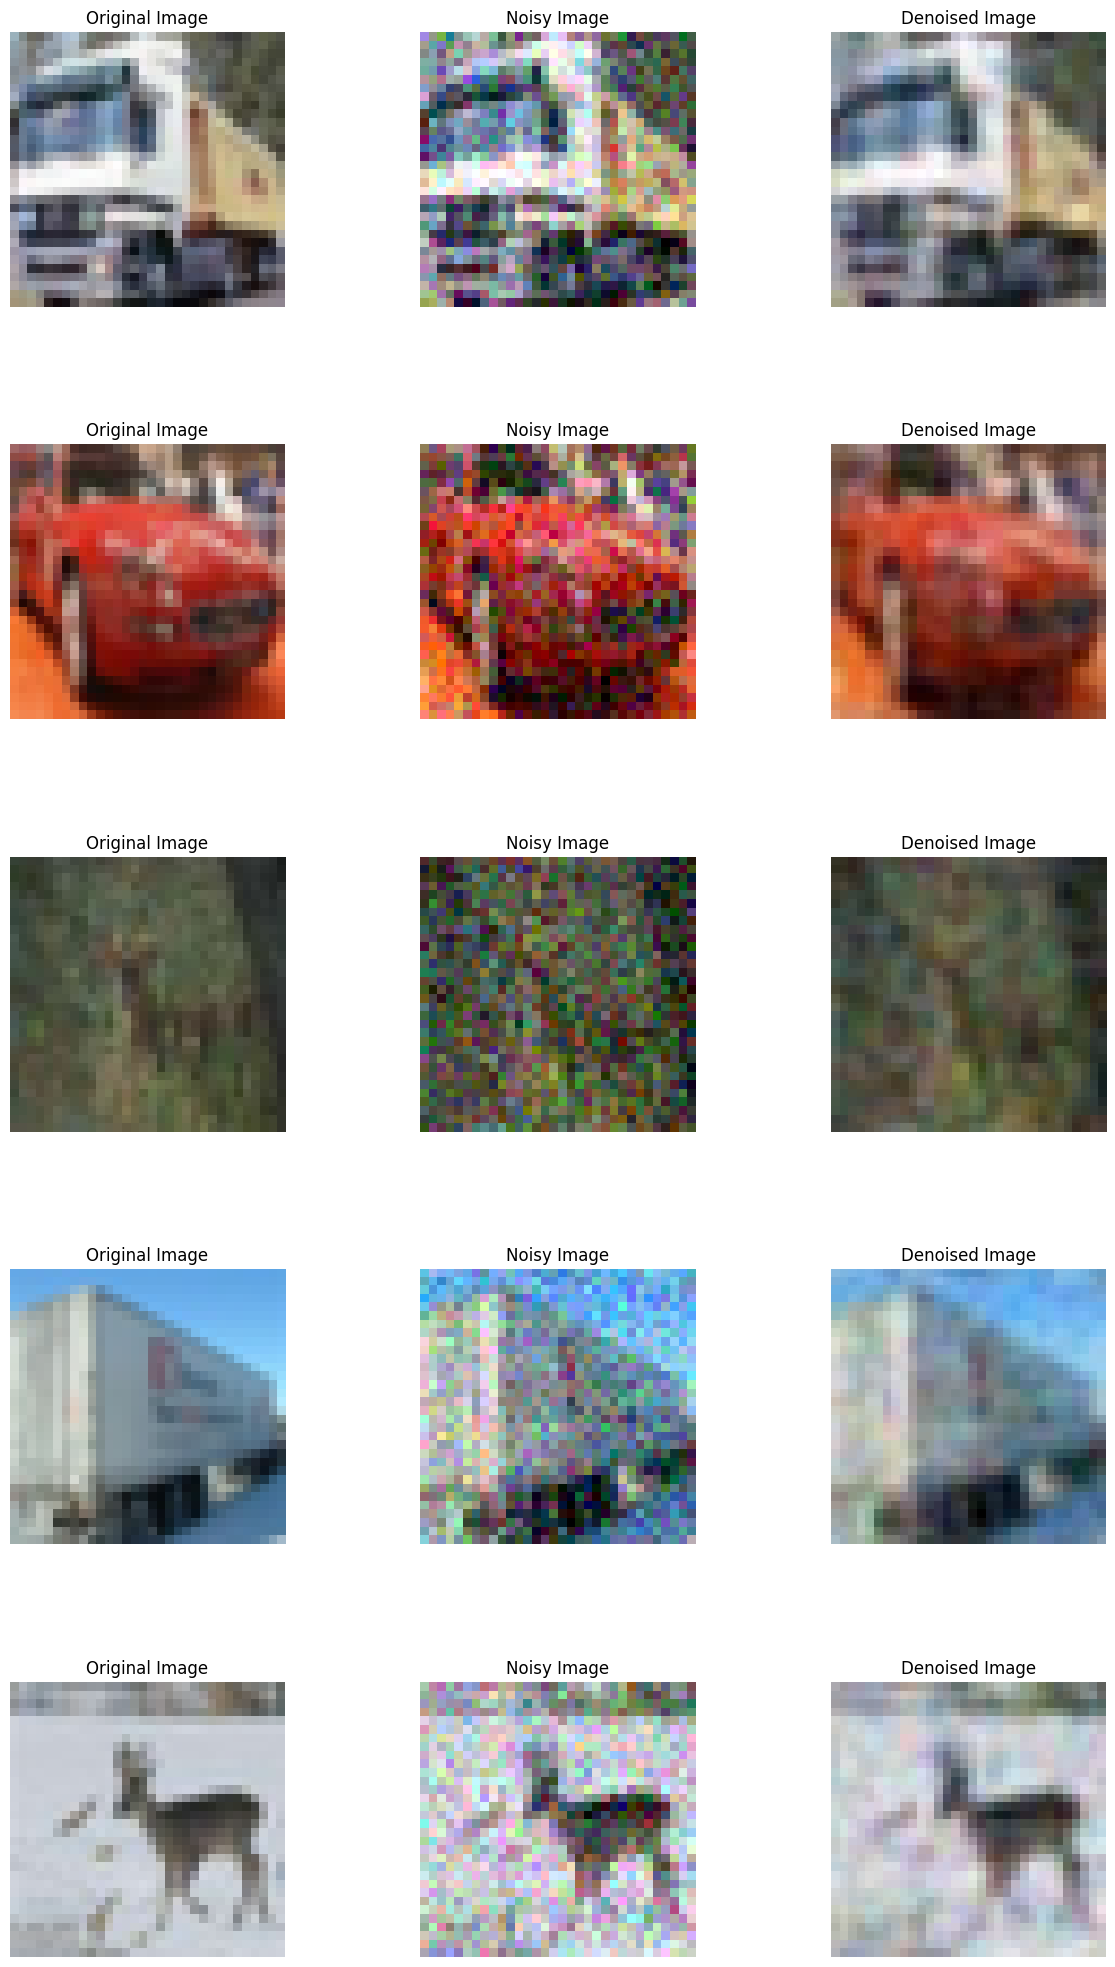

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure values are in [0, 1]
    return noisy_image


transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)


autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


num_epochs = 20
for epoch in range(num_epochs):
    for data in trainloader:
        inputs, _ = data
        noisy_inputs = add_gaussian_noise(inputs)
        optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


def add_gaussian_noise(image, mean=0, std=0.1):
    noise = torch.randn(image.size()) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

def denoise_image(image):
    autoencoder.eval()
    with torch.no_grad():
        denoised_image = autoencoder(image.unsqueeze(0)).squeeze(0)
    return denoised_image

sample_indices = [1, 5, 10, 15, 20]  # Change these indices as needed

num_samples = len(sample_indices)
fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
plt.subplots_adjust(hspace=0.5)

for i, sample_index in enumerate(sample_indices):
    sample_image, _ = trainset[sample_index]
    noisy_image = add_gaussian_noise(sample_image)

    denoised_image = denoise_image(noisy_image)

    axes[i, 0].imshow(sample_image.permute(1, 2, 0))
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(noisy_image.permute(1, 2, 0))
    axes[i, 1].set_title("Noisy Image")
    axes[i, 1].axis('off')

    axes[i, 2].imshow(denoised_image.permute(1, 2, 0))
    axes[i, 2].set_title("Denoised Image")
    axes[i, 2].axis('off')

plt.show()

Bài 3: Cho dataset cifar-10
Giảm chiều dữ liệu về dạng 2d của 1 ảnh bất kỳ bằng 2 phương pháp: PCA và convolution AE.
Visualize và so sánh 2 phương pháp


Files already downloaded and verified


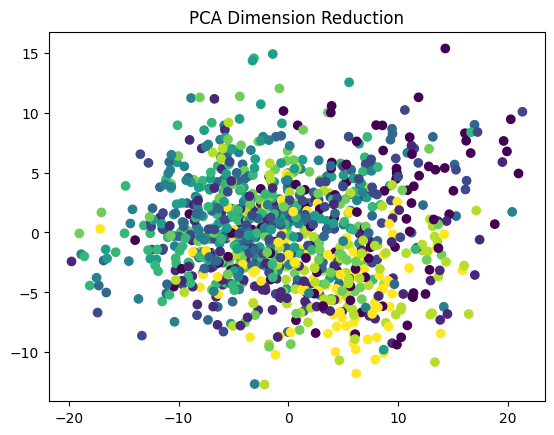

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import transforms
import torchvision.datasets as datasets
import torch
import torch.nn as nn

transform = transforms.Compose([transforms.ToTensor()])
cifar_10_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(cifar_10_data, batch_size=1000, shuffle=False)


images, labels = next(iter(data_loader))


images_np = images.view(images.size(0), -1).numpy()


pca = PCA(n_components=2)
reduced_data_pca = pca.fit_transform(images_np)


plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=labels)
plt.title("PCA Dimension Reduction")
plt.show()


Epoch 1, Loss: 0.0964524058252573
Epoch 2, Loss: 0.04510241858661175
Epoch 3, Loss: 0.03910320192575455
Epoch 4, Loss: 0.037576094940304755
Epoch 5, Loss: 0.03719756253063679
Epoch 6, Loss: 0.037041786015033724
Epoch 7, Loss: 0.03699989713728428
Epoch 8, Loss: 0.036981985792517665
Epoch 9, Loss: 0.03695918321609497
Epoch 10, Loss: 0.03694427669048309


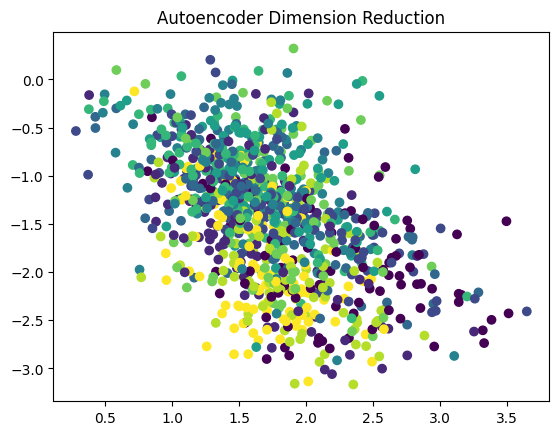

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # 2D embedding
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 3 * 32 * 32)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 3, 32, 32)
        return encoded, decoded

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

for epoch in range(10):
    running_loss = 0.0
    for data in data_loader:
        inputs, _ = data
        optimizer.zero_grad()
        _, outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(data_loader)}")

data_loader = torch.utils.data.DataLoader(cifar_10_data, batch_size=1000, shuffle=False)
images, _ = next(iter(data_loader))
encoded_data, _ = autoencoder(images)
reduced_data_autoencoder = encoded_data.detach().numpy()


plt.scatter(reduced_data_autoencoder[:, 0], reduced_data_autoencoder[:, 1], c=labels)
plt.title("Autoencoder Dimension Reduction")
plt.show()


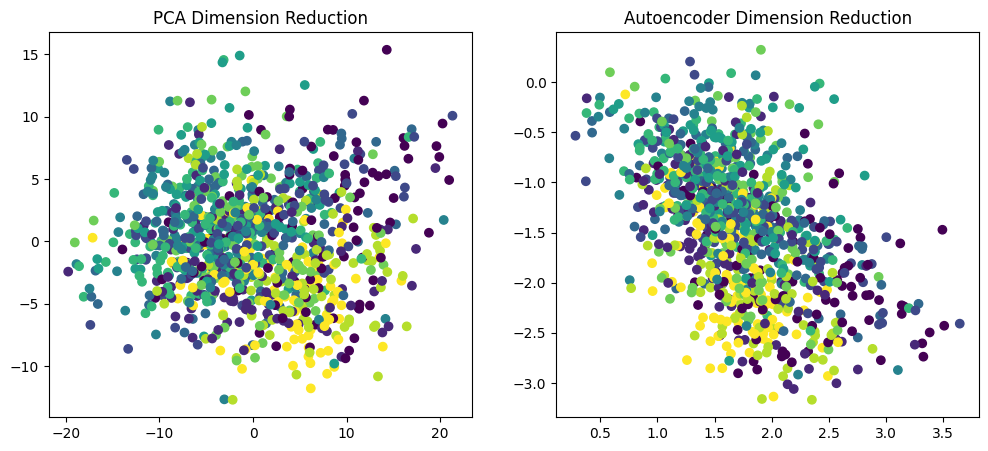

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(reduced_data_pca[:, 0], reduced_data_pca[:, 1], c=labels)
plt.title("PCA Dimension Reduction")

plt.subplot(1, 2, 2)
plt.scatter(reduced_data_autoencoder[:, 0], reduced_data_autoencoder[:, 1], c=labels)
plt.title("Autoencoder Dimension Reduction")

plt.show()
